# Whole Human Brain (WHB) 10x RNA-seq gene expression data (part 1)

The purpose of this set of notebooks is to provide an overview of the data, the file organization and how to combine data and metadata through example use cases.

You need to be connected to the internet to run this notebook or connected to a cache that has the WHB data downloaded already.

The notebook presented here shows quick visualizations from precomputed metadata in the atlas. For examples on accesing the expression matricies, specifically selecting genes from expression matricies, see the ``general_acessing_10x_snRNASeq_tutorial.ipynb`` tutorial/example.

For full details of the data, see [Siletti et al. 2023](https://www.science.org/doi/10.1126/science.add7046).

In [1]:
import os
import pandas as pd
from pathlib import Path
import numpy as np
import anndata
import time
import matplotlib.pyplot as plt

from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache

We will interact with the data using the **AbcProjectCache**. This cache object tracks which data has been downloaded and serves the path to the requsted data on disk. For metadata, the cache can also directly serve a up a Pandas Dataframe from the stored csv file. See the ``getting_started`` notebook for more details on using the cache including installing it if it has not already been.

**Change the download_base variable to where you have downloaded the data in your system.**

In [2]:
version = '20240330'
download_base = Path('../../abc_download_root')
abc_cache = AbcProjectCache.from_s3_cache(download_base)
abc_cache.cache._manifest_file_names = abc_cache.cache.list_all_downloaded_manifests()
abc_cache.load_manifest(f'releases/{version}/manifest.json')
abc_cache.current_manifest

/Users/chris.morrison/src/abc_atlas_access/src/abc_atlas_access/abc_atlas_cache/cloud_cache.py:608: UserWarning: The manifest version recorded as last used for this cache -- releases/20240330/manifest.json-- is not a valid manifest for this dataset. Loading latest version -- releases/20231215/manifest.json -- instead.
  warnings.warn(msg, UserWarning)
/Users/chris.morrison/src/abc_atlas_access/src/abc_atlas_access/abc_atlas_cache/cloud_cache.py:640: OutdatedManifestWarning: You are loading
releases/20231215/manifest.json
which is newer than the most recent manifest file you have previously been working with
releases/20240330/manifest.json
It is possible that some data files have changed between these two data releases, which will force you to re-download those data files (currently downloaded files will not be overwritten). To continue using releases/20240330/manifest.json, run
type.load_manifest('releases/20240330/manifest.json')
  warnings.warn(msg, OutdatedManifestWarning)


'releases/20240330/manifest.json'

## Data overview
### Cell metadata

Essential cell metadata is stored as a dataframe. Each row represents one cell indexed by a *cell label*. The *cell label* is the concatenation of barcode and name of the sample. In this context, the sample is the *barcoded cell sample* that represents a single load into one port of the 10x Chromium. Note that cell barcodes are only unique within a single *barcoded cell sample* and that the same barcode can be reused. The *barcoded cell sample* label or name is unique in the database.

Each cell is associated with a *library label*, *library method*, *donor label*, *donor sex*, dissection *region_of_interest_label*, the corresponding coarse *anatomical division label* and the *matrix_prefix* identifying which data package this cell is part of.

Further, each cell is associated with a *cluster alias* representing which cluster this cell is a member of and (x, y) coordinates of the cells UMAP in Figure 1B. The neurons and non-neurons in the cells table have overlapping (x, y) coordinates and should be plotted seperately.

Below, we load the first of the metadata used in this tutorial. This pattern of loading metadata is repeated throughout the tutorials.

In [3]:
abc_cache.list_metadata_files('WHB-10Xv3')

['anatomical_division_structure_map',
 'cell_metadata',
 'donor',
 'example_genes_all_cells_expression',
 'gene',
 'region_of_interest_structure_map']

In [4]:
abc_cache.list_metadata_files('WHB-taxonomy')

['cluster',
 'cluster_annotation_term',
 'cluster_annotation_term_set',
 'cluster_to_cluster_annotation_membership']

In [5]:
cell = abc_cache.get_metadata_dataframe(
    directory='WHB-10Xv3',
    file_name='cell_metadata',
    dtype={'cell_label': str}
)
cell.set_index('cell_label', inplace=True)
print("Number of cells = ", len(cell))
cell.head(5)
cell.columns

Number of cells =  3369219


Index(['cell_barcode', 'barcoded_cell_sample_label', 'library_label',
       'feature_matrix_label', 'entity', 'brain_section_label',
       'library_method', 'donor_label', 'donor_sex', 'dataset_label', 'x', 'y',
       'cluster_alias', 'region_of_interest_label',
       'anatomical_division_label'],
      dtype='object')

We can use panadas groupby function to see how many unique items are associated for each field and list them out if the number of items is small.

In [6]:
def print_column_info(df):
    
    for c in df.columns:
        grouped = df[[c]].groupby(c).count()
        members = ''
        if len(grouped) < 30:
            members = str(list(grouped.index))
        print("Number of unique %s = %d %s" % (c, len(grouped), members))

In [7]:
print_column_info(cell)

Number of unique cell_barcode = 2205155 
Number of unique barcoded_cell_sample_label = 606 
Number of unique library_label = 606 
Number of unique feature_matrix_label = 2 ['WHB-10Xv3-Neurons', 'WHB-10Xv3-Nonneurons']
Number of unique entity = 1 ['nuclei']
Number of unique brain_section_label = 57 
Number of unique library_method = 1 ['10Xv3']
Number of unique donor_label = 4 ['H18.30.001', 'H18.30.002', 'H19.30.001', 'H19.30.002']
Number of unique donor_sex = 2 ['F', 'M']
Number of unique dataset_label = 1 ['WHB-10Xv3']
Number of unique x = 3369219 
Number of unique y = 3369219 
Number of unique cluster_alias = 3313 
Number of unique region_of_interest_label = 109 
Number of unique anatomical_division_label = 14 ['Amygdaloid complex', 'Basal forebrain', 'Basal nuclei', 'Cerebellum', 'Cerebral cortex', 'Claustrum', 'Extended amygdala', 'Hippocampus', 'Hypothalamus', 'Midbrain', 'Myelencephalon', 'Pons', 'Spinal cord', 'Thalamus']


In [8]:
cell.groupby('dataset_label')[['x']].count()

,x
dataset_label,
WHB-10Xv3,3369219


We can also create a pivot table to associate each cell with terms at each cell type classification level. To do this we need to load multiple other metadata tables and join them into the main cells table. See the ``cluster annotation tutorial`` for more details.

In [9]:
membership = abc_cache.get_metadata_dataframe(
    directory='WHB-taxonomy',
    file_name='cluster_to_cluster_annotation_membership'
)
membership_groupby = membership.groupby(['cluster_alias', 'cluster_annotation_term_set_name'])
membership.head(5)

,cluster_annotation_term_label,cluster_annotation_term_set_label,cluster_alias,cluster_annotation_term_name,cluster_annotation_term_set_name,number_of_cells,color_hex_triplet
0,CS202210140_494,CCN202210140_SUBC,0,URL_297_0,subcluster,34,#7E807A
1,CS202210140_495,CCN202210140_SUBC,1,URL_308_1,subcluster,220,#C54945
2,CS202210140_496,CCN202210140_SUBC,2,URL_308_2,subcluster,187,#5232B7
3,CS202210140_497,CCN202210140_SUBC,3,URL_308_3,subcluster,246,#31BEBA
4,CS202210140_498,CCN202210140_SUBC,4,URL_308_4,subcluster,188,#C8A9BC


In [10]:
term_sets = abc_cache.get_metadata_dataframe(directory='WHB-taxonomy', file_name='cluster_annotation_term_set').set_index('label')
cluster_details = membership_groupby['cluster_annotation_term_name'].first().unstack()
cluster_details = cluster_details[term_sets['name']] # order columns
cluster_details.fillna('Other', inplace=True)
cluster_details.sort_values(['supercluster', 'cluster', 'subcluster'], inplace=True)
cluster_details.head(5)

cluster_annotation_term_set_name,subcluster,cluster,supercluster,neurotransmitter
cluster_alias,,,,
2461,Amex_153_2461,Amex_153,Amygdala excitatory,VGLUT1 VGLUT2
2462,Amex_153_2462,Amex_153,Amygdala excitatory,VGLUT1 VGLUT2
2463,Amex_153_2463,Amex_153,Amygdala excitatory,VGLUT1 VGLUT2
2464,Amex_153_2464,Amex_153,Amygdala excitatory,VGLUT1 VGLUT2
2465,Amex_153_2465,Amex_153,Amygdala excitatory,VGLUT1 VGLUT2


In [11]:
cluster_colors = membership_groupby['color_hex_triplet'].first().unstack()
cluster_colors = cluster_colors[term_sets['name']]
cluster_colors.sort_values(['supercluster', 'cluster', 'subcluster'], inplace=True)
cluster_colors.head(5)

cluster_annotation_term_set_name,subcluster,cluster,supercluster,neurotransmitter
cluster_alias,,,,
2218,#374B8A,#062463,#003380,#2BDFD1
2216,#4BCBC6,#062463,#003380,#2BDFD1
2217,#83C943,#062463,#003380,#2BDFD1
2219,#BC4440,#062463,#003380,#2BDFD1
2220,#CB7ABA,#062463,#003380,#2BDFD1


In [12]:
roi = abc_cache.get_metadata_dataframe(directory='WHB-10Xv3', file_name='region_of_interest_structure_map')
roi.set_index('region_of_interest_label', inplace=True)
roi.rename(columns={'color_hex_triplet': 'region_of_interest_color'},
           inplace=True)
roi.head(5)

,structure_identifier,structure_symbol,structure_name,region_of_interest_color
region_of_interest_label,,,,
Human A13,DHBA:10202,A13,caudal division of OFCi (area 13),#CAB781
Human A14,DHBA:10196,A14r,rostral subdivision of area 14,#B8A26D
Human A14,DHBA:10197,A14c,caudal subdivision of area 14,#B8A26D
Human A19,DHBA:10272,PSC,peristriate cortex (area 19),#D14D46
Human A1C,DHBA:10236,A1C,primary auditory cortex (core),#D670A0


In [13]:
cell_extended = cell.join(cluster_details, on='cluster_alias')
cell_extended = cell_extended.join(cluster_colors, on='cluster_alias', rsuffix='_color')
cell_extended = cell_extended.join(roi[['region_of_interest_color']], on='region_of_interest_label')
cell_extended.head(5)

,cell_barcode,barcoded_cell_sample_label,library_label,feature_matrix_label,entity,brain_section_label,library_method,donor_label,donor_sex,dataset_label,...,anatomical_division_label,subcluster,cluster,supercluster,neurotransmitter,subcluster_color,cluster_color,supercluster_color,neurotransmitter_color,region_of_interest_color
cell_label,,,,,,,,,,,,,,,,,,,,,
10X386_2:CATGGATTCTCGACGG,CATGGATTCTCGACGG,10X386_2,LKTX_210825_01_B01,WHB-10Xv3-Neurons,nuclei,H19.30.001.CX.51,10Xv3,H19.30.001,M,WHB-10Xv3,...,Myelencephalon,URL_312_20,URL_312,Upper rhombic lip,VGLUT1,#4CB941,#97B8C8,#80BAED,#2BDFD1,#5D6CB2
10X383_5:TCTTGCGGTGAATTGA,TCTTGCGGTGAATTGA,10X383_5,LKTX_210818_02_E01,WHB-10Xv3-Neurons,nuclei,H19.30.002.BS.94,10Xv3,H19.30.002,M,WHB-10Xv3,...,Myelencephalon,URL_312_20,URL_312,Upper rhombic lip,VGLUT1,#4CB941,#97B8C8,#80BAED,#2BDFD1,#5D6CB2
10X386_2:CTCATCGGTCGAGCAA,CTCATCGGTCGAGCAA,10X386_2,LKTX_210825_01_B01,WHB-10Xv3-Neurons,nuclei,H19.30.001.CX.51,10Xv3,H19.30.001,M,WHB-10Xv3,...,Myelencephalon,URL_312_17,URL_312,Upper rhombic lip,VGLUT1,#C85E40,#97B8C8,#80BAED,#2BDFD1,#5D6CB2
10X378_8:TTGGATGAGACAAGCC,TTGGATGAGACAAGCC,10X378_8,LKTX_210809_01_H01,WHB-10Xv3-Neurons,nuclei,H19.30.002.BS.93,10Xv3,H19.30.002,M,WHB-10Xv3,...,Pons,URL_312_18,URL_312,Upper rhombic lip,VGLUT1,#61C1C2,#97B8C8,#80BAED,#2BDFD1,#517DBE
10X387_7:TGAACGTAGTATTCCG,TGAACGTAGTATTCCG,10X387_7,LKTX_210825_02_G01,WHB-10Xv3-Neurons,nuclei,H19.30.001.CX.51,10Xv3,H19.30.001,M,WHB-10Xv3,...,Myelencephalon,URL_312_16,URL_312,Upper rhombic lip,VGLUT1,#45328F,#97B8C8,#80BAED,#2BDFD1,#5D6CB2


In [14]:
print_column_info(cell_extended)

Number of unique cell_barcode = 2205155 
Number of unique barcoded_cell_sample_label = 606 
Number of unique library_label = 606 
Number of unique feature_matrix_label = 2 ['WHB-10Xv3-Neurons', 'WHB-10Xv3-Nonneurons']
Number of unique entity = 1 ['nuclei']
Number of unique brain_section_label = 57 
Number of unique library_method = 1 ['10Xv3']
Number of unique donor_label = 4 ['H18.30.001', 'H18.30.002', 'H19.30.001', 'H19.30.002']
Number of unique donor_sex = 2 ['F', 'M']
Number of unique dataset_label = 1 ['WHB-10Xv3']
Number of unique x = 3369219 
Number of unique y = 3369219 
Number of unique cluster_alias = 3313 
Number of unique region_of_interest_label = 109 
Number of unique anatomical_division_label = 14 ['Amygdaloid complex', 'Basal forebrain', 'Basal nuclei', 'Cerebellum', 'Cerebral cortex', 'Claustrum', 'Extended amygdala', 'Hippocampus', 'Hypothalamus', 'Midbrain', 'Myelencephalon', 'Pons', 'Spinal cord', 'Thalamus']
Number of unique subcluster = 3313 
Number of unique clu

### UMAP spatial embedding

Now that we've merged the cluster metadata into the main cells data, we can plot the Uniform Manifold Approximation and Projection (UMAP) for all the cells in the dataset using information from the cluster information. The UMAP is a dimension reduction technique that can be used for visualizing and exploring large-dimension datasets. The x, y columns of the cell metadata table represents the coordinate of the all cells UMAP in Figure 1B of the manuscript.  Note that the (x, y) coordinates for Neuron and Non-neuron cells overlap and should be plotted seperately.

We define a small helper function *plot umap* to visualize the cells on the UMAP colorized by: dissection region of interest, neurotransmitter identity, cell types division, supercluster, cluster, and subcluster. For ease of demostration, we do a simple subsampling of the cells by a factor of 10 to reduce processing time.

In [15]:
def plot_umap(xx, yy, cc=None, val=None, fig_width=8, fig_height=8, cmap=None):

    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)

    if cmap is not None:
        plt.scatter(xx, yy, s=0.5, c=val, marker='.', cmap=cmap)
    elif cc is not None:
        plt.scatter(xx, yy, s=0.5, color=cc, marker='.')
        
    ax.axis('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    
    return fig, ax

In [16]:
neurons_subsampled = cell_extended[cell_extended['feature_matrix_label'] == 'WHB-10Xv3-Neurons'][::10]
non_neurons_subsampled = cell_extended[cell_extended['feature_matrix_label'] == 'WHB-10Xv3-Nonneurons'][::10]
print("n neurons to plot:", len(neurons_subsampled))
print("n non-neurons to plot:", len(non_neurons_subsampled))

n neurons to plot: 303681
n non-neurons to plot: 107871


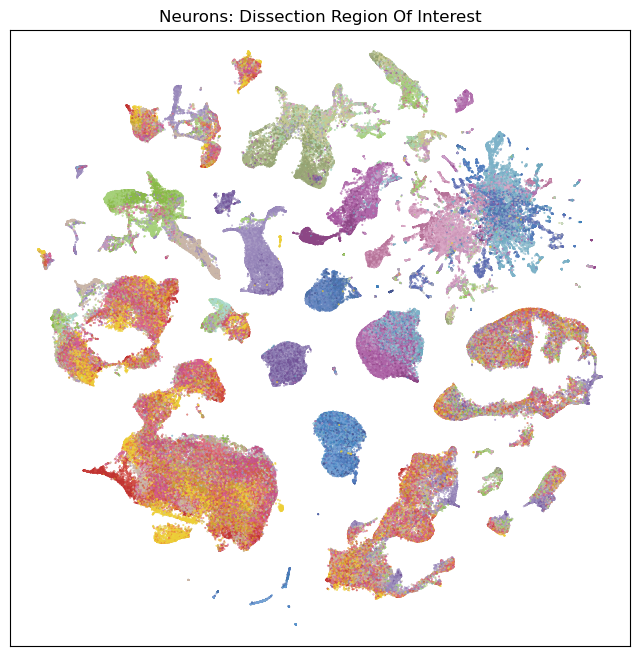

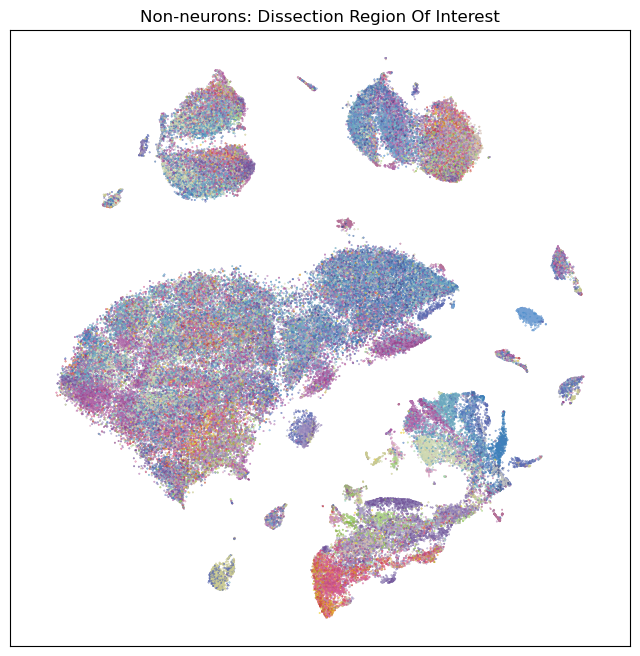

In [17]:
fig, ax = plot_umap(neurons_subsampled['x'], neurons_subsampled['y'], cc=neurons_subsampled['region_of_interest_color'])
res = ax.set_title("Neurons: Dissection Region Of Interest")
fig, ax = plot_umap(non_neurons_subsampled['x'], non_neurons_subsampled['y'], cc=non_neurons_subsampled['region_of_interest_color'])
res = ax.set_title("Non-neurons: Dissection Region Of Interest")

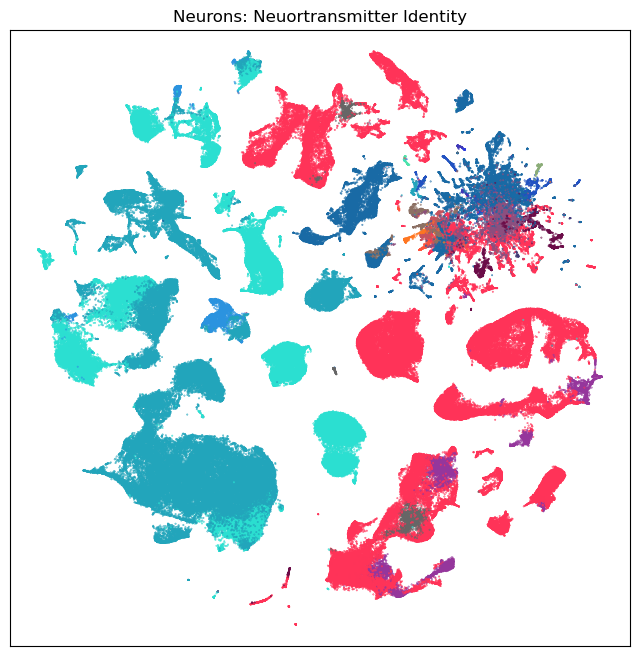

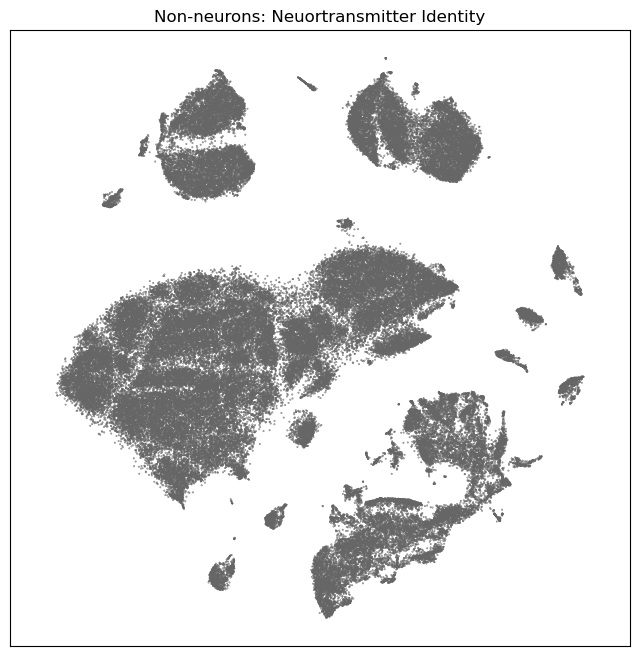

In [18]:
fig, ax = plot_umap(neurons_subsampled['x'], neurons_subsampled['y'], cc=neurons_subsampled['neurotransmitter_color'])
res = ax.set_title("Neurons: Neuortransmitter Identity")
fig, ax = plot_umap(non_neurons_subsampled['x'], non_neurons_subsampled['y'], cc=non_neurons_subsampled['neurotransmitter_color'])
res = ax.set_title("Non-neurons: Neuortransmitter Identity")

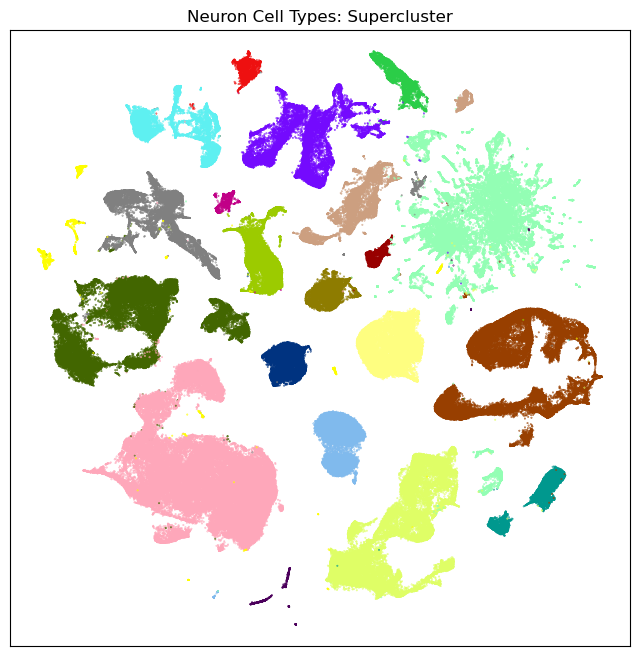

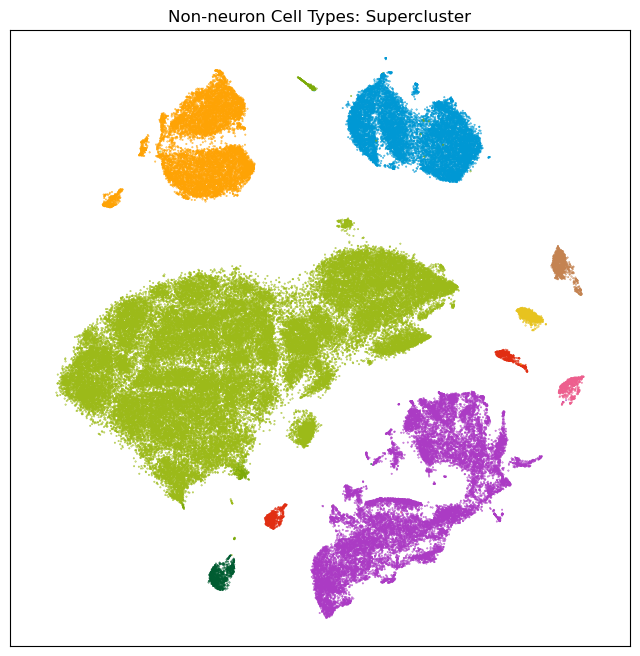

In [19]:
fig, ax = plot_umap(neurons_subsampled['x'], neurons_subsampled['y'], cc=neurons_subsampled['supercluster_color'])
res = ax.set_title("Neuron Cell Types: Supercluster")
fig, ax = plot_umap(non_neurons_subsampled['x'], non_neurons_subsampled['y'], cc=non_neurons_subsampled['supercluster_color'])
res = ax.set_title("Non-neuron Cell Types: Supercluster")

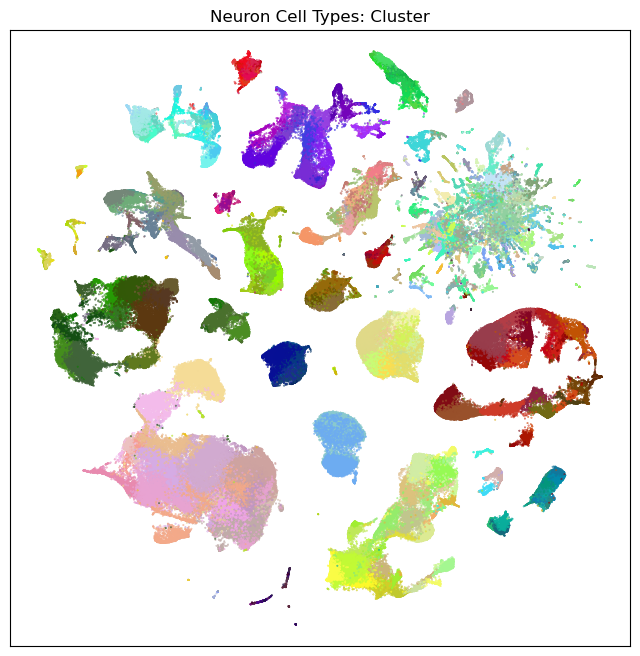

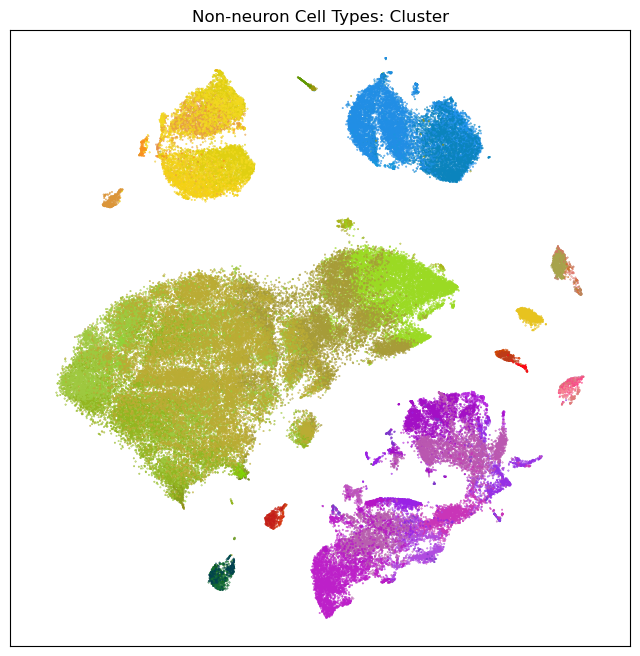

In [20]:
fig, ax = plot_umap(neurons_subsampled['x'], neurons_subsampled['y'], cc=neurons_subsampled['cluster_color'])
res = ax.set_title("Neuron Cell Types: Cluster")
fig, ax = plot_umap(non_neurons_subsampled['x'], non_neurons_subsampled['y'], cc=non_neurons_subsampled['cluster_color'])
res = ax.set_title("Non-neuron Cell Types: Cluster")

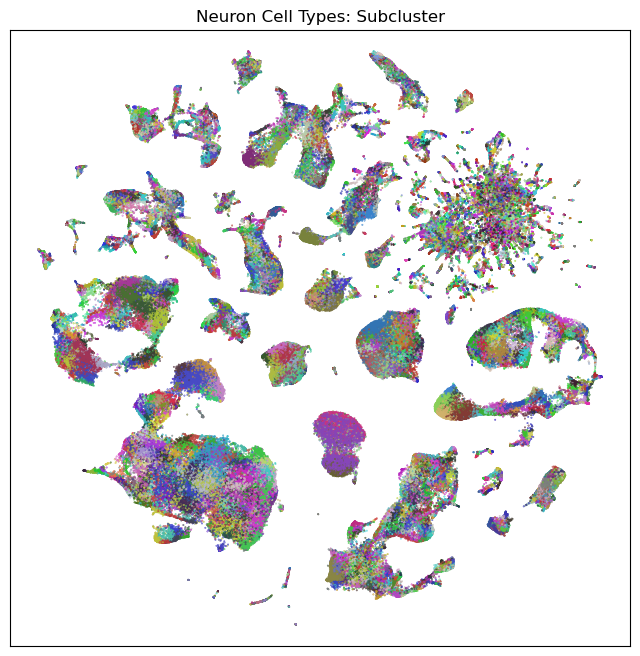

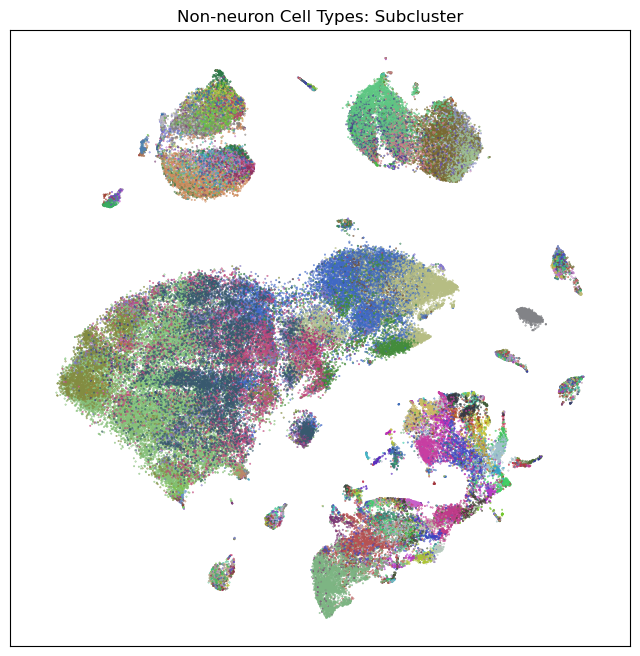

In [21]:
fig, ax = plot_umap(neurons_subsampled['x'], neurons_subsampled['y'], cc=neurons_subsampled['subcluster_color'])
res = ax.set_title("Neuron Cell Types: Subcluster")
fig, ax = plot_umap(non_neurons_subsampled['x'], non_neurons_subsampled['y'], cc=non_neurons_subsampled['subcluster_color'])
res = ax.set_title("Non-neuron Cell Types: Subcluster")

**In part 2 we'll focus on gene data including using the UMAP to plot gene expression locations in the different clusterings.**